In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [ ]:
image = cv2.imread('2-no.jpeg')
#new_image = crop_brain_contour(image) # agr plot true na ho to by default ye array h 
#new_image

In [3]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [4]:
import os
augmented_path =r'C:\Users\Muhammad Usama Abid\Desktop\uni\augmented_data'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = os.path.join(augmented_path , 'yes')
augmented_no = os.path.join(augmented_path , 'no')

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [5]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [7]:
def build_model(input_shape):
  
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [8]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [9]:
model = build_model(IMG_SHAPE)

In [10]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [14]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 205s 4s/step - loss: 0.2692 - accuracy: 0.6318 - val_loss: 0.2411 - val_accuracy: 0.5355
Epoch 2/10
46/46 [==============================] - 131s 3s/step - loss: 0.1670 - accuracy: 0.7709 - val_loss: 0.2048 - val_accuracy: 0.6645
Epoch 3/10
46/46 [==============================] - 131s 3s/step - loss: 0.1340 - accuracy: 0.8138 - val_loss: 0.1766 - val_accuracy: 0.7484
Epoch 4/10
46/46 [==============================] - 130s 3s/step - loss: 0.1072 - accuracy: 0.8574 - val_loss: 0.1924 - val_accuracy: 0.6968
Epoch 5/10
46/46 [==============================] - 132s 3s/step - loss: 0.1190 - accuracy: 0.8388 - val_loss: 0.2301 - val_accuracy: 0.6258
Epoch 6/10
46/46 [==============================] - 148s 3s/step - loss: 0.1083 - accuracy: 0.8561 - val_loss: 0.1524 - val_accuracy: 0.7968
Epoch 7/10
46/46 [==============================] - 163s 4s/step - loss: 0.0800 - accuracy: 0.9052 - val_loss: 0.1209 - val_accuracy: 0.8516
Epoch 8/10
46

In [15]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [16]:
history = model.history.history
print(history)

{'loss': [0.2691504955291748, 0.16700546443462372, 0.13395479321479797, 0.10722462832927704, 0.11895495653152466, 0.10825496166944504, 0.07999692112207413, 0.07267087697982788, 0.07243605703115463, 0.057007912546396255], 'accuracy': [0.6318339109420776, 0.7709342837333679, 0.8138408064842224, 0.8574394583702087, 0.8387542963027954, 0.8560553789138794, 0.9051902890205383, 0.9093425869941711, 0.9065743684768677, 0.9321799278259277], 'val_loss': [0.24108576774597168, 0.20484575629234314, 0.17662282288074493, 0.1924430876970291, 0.2301061749458313, 0.15237867832183838, 0.1208500862121582, 0.1026911735534668, 0.09234009683132172, 0.09412223100662231], 'val_accuracy': [0.5354838967323303, 0.6645161509513855, 0.7483870983123779, 0.6967741847038269, 0.625806450843811, 0.7967742085456848, 0.85161292552948, 0.8580645322799683, 0.8935483694076538, 0.8838709592819214]}


In [17]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


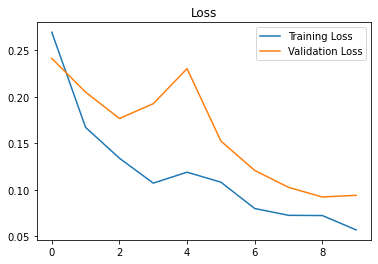

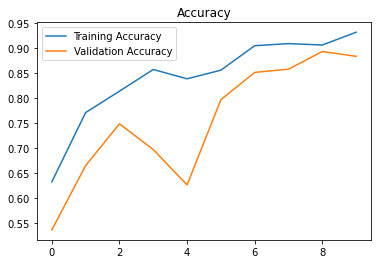

In [18]:
plot_metrics(history)

In [19]:
loss, acc = model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 5s 492ms/step - loss: 0.1045 - accuracy: 0.8742


In [20]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.10452413558959961
Test Accuracy = 0.874193549156189


In [ ]:
model.save('brain-tumor-detection-CNN.h5')

In [27]:
json_string = model.to_json()
json_string

'{"class_name": "Model", "config": {"name": "BrainDetectionModel", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 240, 240, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "zero_padding2d", "trainable": true, "dtype": "float32", "padding": [[2, 2], [2, 2]], "data_format": "channels_last"}, "name": "zero_padding2d", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv0", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [7, 7], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer"

In [29]:
new_model = load_model('brain-tumor-detection-CNN.h5')
new_model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [25]:
#predictions = model.predict(X_test ,batch_size= 10, verbose = 0) 
predictions = model.predict(X)

In [26]:
for i in predictions:
    print(i)

[0.01098412]
[0.89098465]
[0.3316557]
[0.9936309]
[0.83721596]
[0.43230045]
[0.9899854]
[0.48833218]
[0.84176993]
[0.99036986]
[0.07447517]
[0.6909166]
[0.9511303]
[0.19113359]
[0.4982268]
[0.9997488]
[0.72444665]
[0.00741944]
[0.02720129]
[0.88252646]
[0.07834363]
[0.09321856]
[0.40968147]
[0.9897764]
[0.35901827]
[0.18479383]
[0.9804704]
[0.28329682]
[0.6208181]
[0.05963367]
[0.70057267]
[0.9892367]
[0.54889256]
[0.16457671]
[0.1406982]
[0.73562497]
[0.16168562]
[0.50086236]
[0.3200208]
[0.01715946]
[0.93719935]
[0.9210937]
[0.88967323]
[0.85994244]
[0.9858769]
[0.99749804]
[0.02365661]
[0.98615396]
[0.9760587]
[0.6106385]
[0.07651383]
[0.12589267]
[0.04920146]
[0.00224361]
[0.6236172]
[0.17645097]
[0.01719591]
[0.13160154]
[0.660634]
[0.720593]
[0.9150437]
[0.02451947]
[0.30865592]
[0.6379918]
[0.9675274]
[0.07564369]
[0.01794389]
[0.03186452]
[0.9461]
[0.21970573]
[0.08075526]
[0.07670119]
[0.07768688]
[0.03195101]
[0.01812074]
[0.28299147]
[0.23474398]
[0.34269488]
[0.00403956]
[0

[0.31010467]
[0.00882229]
[0.827309]
[0.17314029]
[0.9496008]
[0.3069508]
[0.9564378]
[0.8677974]
[0.12272593]
[0.9819428]
[0.279661]
[0.0179961]
[0.821167]
[0.2875922]
[0.9847009]
[0.6033666]
[0.07185137]
[0.08476475]
[0.04192784]
[0.02020642]
[0.9722738]
[0.9966854]
[0.88620174]
[0.7670181]
[0.16000313]
[0.21369767]
[0.8581637]
[0.01443014]
[0.728135]
[0.24064758]
[0.13205147]
[0.03335202]
[0.58423626]
[0.17624372]
[0.02292198]
[0.44126785]
[0.6975073]
[0.9824079]
[0.39129543]
[0.9740932]
[0.57974136]
[0.46547496]
[0.29518074]
[0.0607293]
[0.78544974]
[0.16611645]
[0.03342319]
[0.8698895]
[0.7702099]
[0.16930741]
[0.73274064]
[0.06468138]
[0.702389]
[0.96239305]
[6.802499e-05]
[0.00145388]
[0.95160794]
[0.7294975]
[0.9256996]
[0.94149864]
[0.92737013]
[0.06851763]
[0.8416716]
[0.960426]
[0.87479556]
[0.9923574]
[0.05087104]
[0.75620306]
[0.1811508]
[0.9472451]
[0.03586403]
[0.82933867]
[0.44591823]
[0.02328834]
[0.010647]
[0.31502533]
[0.929041]
[0.8013071]
[0.02858558]
[0.02423322]


[0.7869847]
[0.09387186]
[0.00897965]
[0.38442194]
[0.9474689]
[0.08883959]
[0.01196805]
[0.53662026]
[0.02038035]
[0.9518862]
[0.24439722]
[0.13797519]
[0.9035539]
[0.6211747]
[0.8643333]
[0.99921477]
[0.8985006]
[0.12047997]
[0.8546939]
[0.15490967]
[0.9654907]
[0.9797777]
[0.96780527]
[0.99352926]
[0.1236673]
[0.07474861]
[0.3141049]
[0.00247854]
[0.92087203]
[0.79784286]
[0.01010594]
[0.11366522]
[0.90989316]
[0.36931264]
[0.80738294]
[0.96315145]
[0.9408871]
[0.98703134]
[0.69874537]
[0.3333869]
[0.04878232]
[0.8785169]
[0.01547885]
[0.8976806]
[0.9992859]
[0.05938503]
[0.07176334]
[0.01286376]
[0.0845992]
[0.6858723]
[0.9891238]
[0.4460017]
[0.5216467]
[0.10229626]
[0.97033095]
[0.90991515]
[0.9165542]
[0.9250759]
[0.983348]
[0.9559468]
[0.9698856]
[0.11135823]
[0.11870238]
[0.88753825]
[0.3680967]
[0.9409207]
[0.73245096]
[0.13703516]
[0.53042495]
[0.7606775]
[0.3003407]
[0.04239413]
[0.01516321]
[0.83695614]
[0.5931177]
[0.99874187]
[0.85442674]
[0.30803084]
[0.13896629]
[0.993

In [ ]:
catig = ["yes", "no"]
rounded_predictions = model.predict_classes(X_test ,batch_size= 10, verbose = 0)
#predictions = model.predict(X_test ,batch_size= 10, verbose = 0)


In [ ]:
for i in predictions:
    print(i)
    #n = int(i)
    
    #print(catig[int(predictions[n])])
    